In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import magic
import shutil
import librosa
import cv2
from sklearn.metrics import mean_squared_error

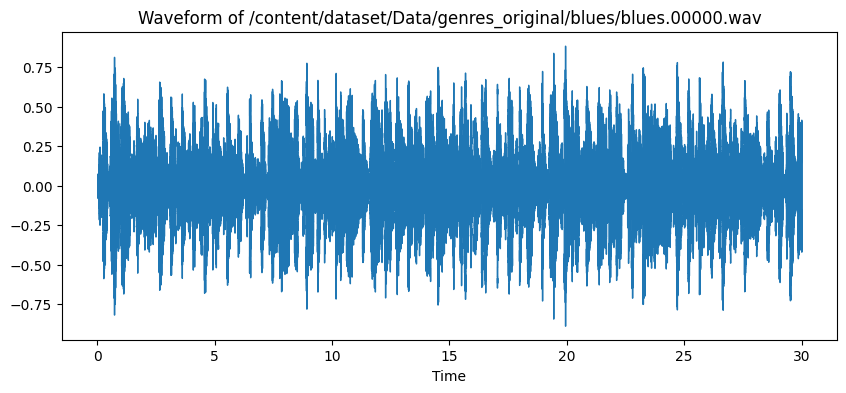

In [2]:
audio_files_path = '/content/dataset/Data/genres_original/blues/'
audio_file = os.path.join(audio_files_path, 'blues.00000.wav')
audio_data, sr = librosa.load(audio_file, sr=None)

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_data, sr=sr)
plt.title(f'Waveform of {audio_file}')
plt.show()

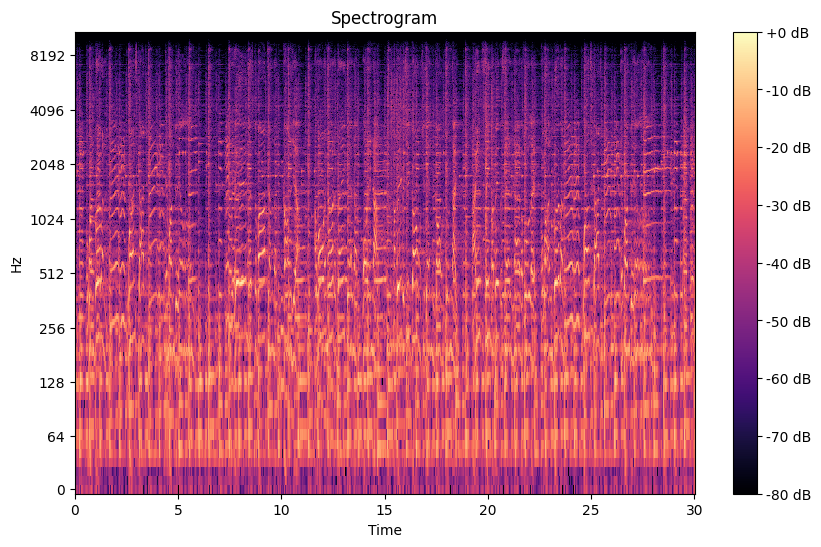

In [3]:
D = librosa.stft(audio_data)
D_db = librosa.amplitude_to_db(abs(D), ref=np.max)

plt.figure(figsize=(10, 6))
librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

In [4]:
def preprocess_audio(file_path):
    audio_data, sr = librosa.load(file_path, sr=None)
    D = librosa.stft(audio_data)
    D_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    return D_db

audio_data = []
for file_name in os.listdir(audio_files_path):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_files_path, file_name)
        spectrogram = preprocess_audio(file_path)
        audio_data.append(spectrogram)

audio_data = np.array(audio_data)

print(audio_data.shape)

(100, 1025, 1293)


In [5]:
def preprocess_audio(file_path):
    audio_data, sr = librosa.load(file_path, sr=None)
    D = librosa.stft(audio_data)
    D_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    D_resized = cv2.resize(D_db, (256, 256))
    D_resized = (D_resized - np.min(D_resized)) / (np.max(D_resized) - np.min(D_resized))
    D_resized = np.expand_dims(D_resized, axis=-1)
    return D_resized

audio_data = []
for file_name in os.listdir(audio_files_path):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_files_path, file_name)
        spectrogram = preprocess_audio(file_path)
        audio_data.append(spectrogram)

audio_data = np.array(audio_data)
print(audio_data.shape)

(100, 256, 256, 1)


In [7]:
def build_generator():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(256, 256, 1)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid'))
    model.add(layers.Resizing(256, 256))
    return model

def build_discriminator():
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(256, 256, 1)))
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='linear'))
    return model

generator = build_generator()
discriminator = build_discriminator()

gan_input = layers.Input(shape=(256, 256, 1))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = models.Model(gan_input, gan_output)

discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan.compile(optimizer='adam', loss='binary_crossentropy')

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(audio_data, test_size=0.2, random_state=42)

print(X_train.shape, X_val.shape)

(80, 256, 256, 1) (20, 256, 256, 1)


In [9]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

discriminator.compile(optimizer='adam', loss=wasserstein_loss)

gan.compile(optimizer='adam', loss=wasserstein_loss)

In [10]:
batch_size = 16
epochs = 30

def train_gan(X_train, generator, discriminator, gan, batch_size, epochs):
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 256, 256, 1))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, -np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.ones((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch(noise, -np.ones((batch_size, 1)))

        if epoch % 1000 == 0:
            print(f"Epoch: {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

train_gan(X_train, generator, discriminator, gan, batch_size, epochs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0, D Loss: -0.024702761322259903, G Loss: [array(-0.00389236, dtype=float32), array(-0.00389236, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [13]:
noise = np.random.normal(0, 1, (1, 256, 256, 1))

restored_spectrogram = generator.predict(noise)
print(f"Spectrogram shape: {restored_spectrogram.shape}")
if restored_spectrogram.size == 0:
    print("Error: The restored spectrogram is empty.")
else:
    restored_spectrogram = restored_spectrogram[0, :, :, 0]
    print(f"Restored spectrogram shape after reshaping: {restored_spectrogram.shape}")

    initial_phase = np.exp(2j * np.pi * np.random.rand(*restored_spectrogram.shape))

    complex_spectrogram = restored_spectrogram * initial_phase

    restored_audio = librosa.istft(complex_spectrogram)

    print(f"Restored audio shape: {restored_audio.shape}")
    print(f"Length of restored_audio: {len(restored_audio)}")
    restored_audio = np.clip(restored_audio, -1.0, 1.0)
    restored_audio_int16 = np.int16(restored_audio * 32767)
    restored_audio_int16 = restored_audio_int16.reshape(-1)
    sf.write('restored_audio.wav', restored_audio_int16, 16000)

    print("Restored audio saved successfully.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
Spectrogram shape: (1, 256, 256, 1)
Restored spectrogram shape after reshaping: (256, 256)
Restored audio shape: (32385,)
Length of restored_audio: 32385
Restored audio saved successfully.


In [18]:
def preprocess_audio(file_path):
    audio_data, sr = librosa.load(file_path, sr=None)
    D = librosa.stft(audio_data)
    D_db = librosa.amplitude_to_db(abs(D), ref=np.max)
    return D_db

real_images = []

for file_name in os.listdir(audio_files_path):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_files_path, file_name)
        spectrogram = preprocess_audio(file_path)
        real_images.append(spectrogram)

real_images = np.array(real_images)

resized_real_images = np.array([cv2.resize(img, (256, 256)) for img in real_images])
print(f"Resized real images shape: {resized_real_images.shape}")

single_real_image = resized_real_images[0]
print(f"Single real image shape: {single_real_image.shape}")

flattened_real = single_real_image.flatten()
resized_restored_spectrogram = cv2.resize(restored_spectrogram[0].squeeze(), (256, 256))
flattened_restored = resized_restored_spectrogram.flatten()

print(f"Flattened real spectrogram length: {len(flattened_real)}")
print(f"Flattened restored spectrogram length: {len(flattened_restored)}")

mse = mean_squared_error(flattened_real, flattened_restored)
print(f"Mean Squared Error: {mse}")

Resized real images shape: (100, 256, 256)
Single real image shape: (256, 256)
Flattened real spectrogram length: 65536
Flattened restored spectrogram length: 65536
Mean Squared Error: 4751.857421875


In [20]:
gan.save("gan_model.keras")
print("GAN model saved as 'gan_model.keras'")

GAN model saved as 'gan_model.keras'
